In [22]:
# !wget https://i.pinimg.com/736x/75/b0/e4/75b0e4afc19dcf85e5e90a3c7725b84b.jpg
!wget https://live.staticflickr.com/8043/8394379683_a49795d0e3_b.jpg

--2024-10-27 07:41:54--  https://live.staticflickr.com/8043/8394379683_a49795d0e3_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.238.247.73, 2600:9000:2090:2800:0:5a51:64c9:c681, 2600:9000:2090:8a00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.238.247.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘8394379683_a49795d0e3_b.jpg’

8394379683_a49795d0     [ <=>                ] 149.00K  --.-KB/s    in 0.009s  

2024-10-27 07:41:54 (15.9 MB/s) - ‘8394379683_a49795d0e3_b.jpg’ saved [152571]



# Gray scale conversion

Time taken: 0.17897319793701172 seconds


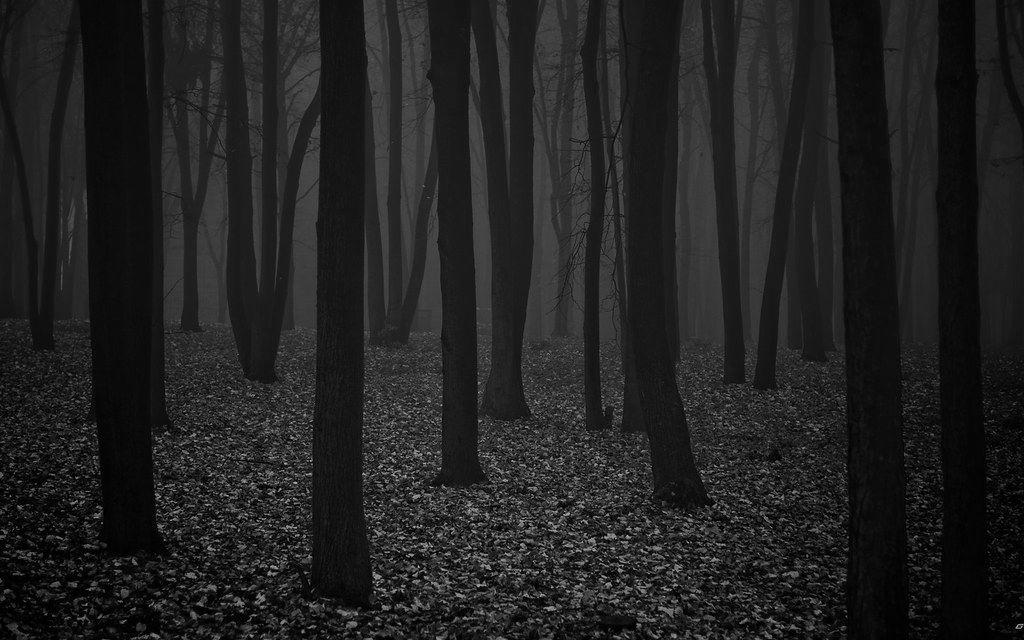

In [23]:
from PIL import Image
import time
from IPython.display import display
from numba import cuda
import numpy as np

# Function to convert the image to grayscale on the GPU
@cuda.jit
def rgb_to_gray_gpu(rgb_array, gray_array):
    x, y = cuda.grid(2)
    if x < rgb_array.shape[0] and y < rgb_array.shape[1]:
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        # Average formula for grayscale
        gray_value = (r + g + b) // 3
        gray_array[x, y] = gray_value

# Start the timer
start_time = time.time()

# Load the image and convert to NumPy array
img = Image.open('/content/8394379683_a49795d0e3_b.jpg')
rgb_array = np.array(img)

# Create an empty array for the grayscale image
gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

# Define the block and grid size for GPU execution
threads_per_block = 16  # Single number for the 2D block size (16x16)
blocks_per_grid_x = int(np.ceil(rgb_array.shape[0] / threads_per_block))
blocks_per_grid_y = int(np.ceil(rgb_array.shape[1] / threads_per_block))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Copy data to the GPU
rgb_array_device = cuda.to_device(rgb_array)
gray_array_device = cuda.to_device(gray_array)

# Run the kernel on the GPU
rgb_to_gray_gpu[blocks_per_grid, (threads_per_block, threads_per_block)](rgb_array_device, gray_array_device)

# Copy the result back to the host
gray_array_device.copy_to_host(gray_array)

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Convert the grayscale array back to an image
gray_img = Image.fromarray(gray_array)

# Display the grayscale image using IPython
display(gray_img)


# Find max min

In [24]:

# Kernel function to find min and max in a 2D array
@cuda.jit
def find_min_max_kernel(src, min_array, max_array):
    # Define the shared memory size based on block size
    shared_size = cuda.shared.array((256,), dtype=np.float32)  # Adjust size as needed
    local_min = cuda.shared.array((256,), dtype=np.float32)
    local_max = cuda.shared.array((256,), dtype=np.float32)

    # Calculate global thread index
    global_tid = cuda.grid(1)

    # Load data into shared memory
    if global_tid < src.size:
        shared_size[cuda.threadIdx.x] = src[global_tid]
    else:
        shared_size[cuda.threadIdx.x] = float('inf')  # Set to inf for min
    cuda.syncthreads()

    # Reduction for minimum
    s = cuda.blockDim.x // 2
    while s > 0:
        if cuda.threadIdx.x < s:
            shared_size[cuda.threadIdx.x] = min(shared_size[cuda.threadIdx.x], shared_size[cuda.threadIdx.x + s])
        cuda.syncthreads()
        s //= 2

    # Only the first thread writes the result back for min
    if cuda.threadIdx.x == 0:
        min_array[cuda.blockIdx.x] = shared_size[0]

    # Load data into shared memory again for max
    if global_tid < src.size:
        shared_size[cuda.threadIdx.x] = src[global_tid]
    else:
        shared_size[cuda.threadIdx.x] = float('-inf')  # Set to -inf for max
    cuda.syncthreads()

    # Reduction for maximum
    s = cuda.blockDim.x // 2
    while s > 0:
        if cuda.threadIdx.x < s:
            shared_size[cuda.threadIdx.x] = max(shared_size[cuda.threadIdx.x], shared_size[cuda.threadIdx.x + s])
        cuda.syncthreads()
        s //= 2

    # Only the first thread writes the result back for max
    if cuda.threadIdx.x == 0:
        max_array[cuda.blockIdx.x] = shared_size[0]

# Function to launch the kernel
def find_min_max(src):
    # Determine grid and block dimensions
    n = src.size
    block_size = 256  # Adjust as needed
    grid_size = (n + block_size - 1) // block_size

    # Allocate arrays for min and max results
    min_array = np.full(grid_size, float('inf'), dtype=np.float32)
    max_array = np.full(grid_size, float('-inf'), dtype=np.float32)

    # Transfer data to GPU
    d_src = cuda.to_device(src)
    d_min = cuda.to_device(min_array)
    d_max = cuda.to_device(max_array)

    # Launch kernel
    find_min_max_kernel[grid_size, block_size](d_src, d_min, d_max)

    # Copy results back to host
    min_results = d_min.copy_to_host()
    max_results = d_max.copy_to_host()

    # Final min and max reduction on the host
    final_min = min(min_results)
    final_max = max(max_results)

    return final_min, final_max


# Flatten the 2D array for processing
flattened_array = gray_array.flatten()

# Call the function
min_val, max_val = find_min_max(flattened_array)
print("Minimum value:", min_val)
print("Maximum value:", max_val)


Minimum value: 0.0
Maximum value: 188.0


# Grayscale Stretch

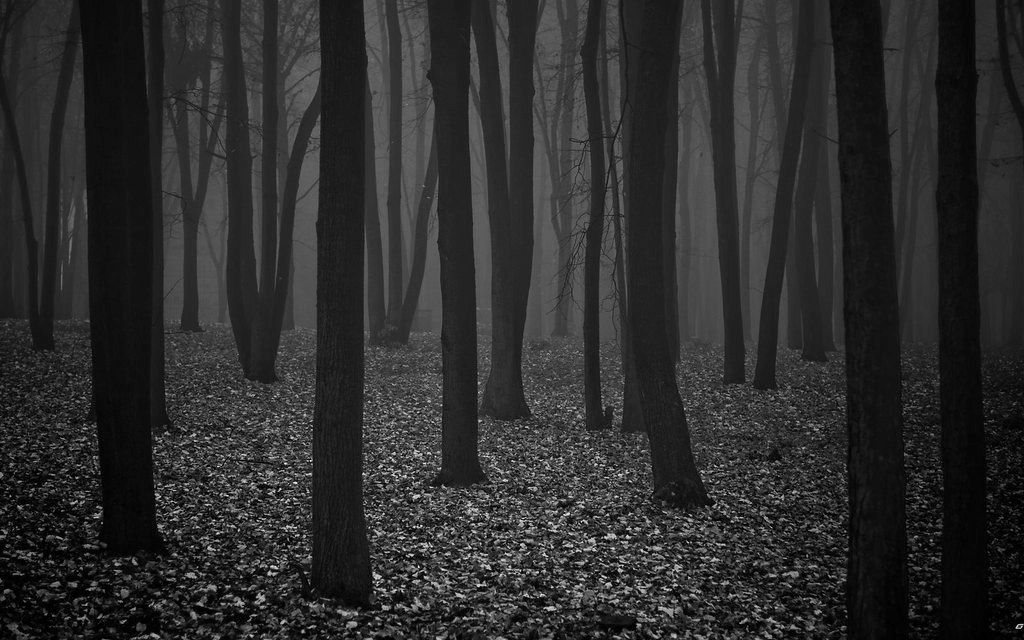

In [25]:
import numpy as np
from numba import cuda

# Kernel function to normalize pixel values
@cuda.jit
def normalize_kernel(src, dst, min_val, max_val):
    # Calculate the global thread index
    x, y = cuda.grid(2)  # Get 2D grid coordinates

    # Check bounds
    if x < src.shape[0] and y < src.shape[1]:
        old_pixel_value = src[x, y]
        # Normalize the pixel value using the formula
        normalized_value = (old_pixel_value - min_val) / (max_val - min_val) * 255
        # dst[x, y] = normalized_value.astype(np.uint8)  # Store as uint8
        dst[x, y] = np.uint8(normalized_value)

# Function to launch the normalization kernel
def normalize_image(src, min_val, max_val):
    # Create an output array
    dst = np.empty_like(src, dtype=np.uint8)

    # Define grid and block dimensions
    threads_per_block = (16, 16)  # 16x16 threads per block
    blocks_per_grid_x = (src.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (src.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Transfer data to GPU
    d_src = cuda.to_device(src)
    d_dst = cuda.to_device(dst)

    # Launch kernel
    normalize_kernel[blocks_per_grid, threads_per_block](d_src, d_dst, min_val, max_val)

    # Copy the result back to the host
    d_dst.copy_to_host(dst)

    return dst


# Normalize the image
normalized_array = normalize_image(gray_array, min_val, max_val)

# Convert the grayscale array back to an image
norm_img = Image.fromarray(normalized_array)

# Display the grayscale image using IPython
display(norm_img)
